<a href="https://colab.research.google.com/github/alemarbra44/Job-Sample-Data-Intern-Alejandro-Bravo-Angulo-/blob/main/Job_Sample%E2%80%94Data_Intern%E2%80%94%5BAlejandro_Bravo_Angulo%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1 - Data Cleaning & Organization in Salesforce**

**Data Cleaning: Identify and fix inconsistencies, missing values, or duplicates**.

In [1]:
# installar librerias necesarias (solo usarlo al inicio)
!pip install gspread pandas gspread_dataframe --quiet
# el ! al inicio indica que se ejecute un comando del sistema (como en el terminal)
# pip install sirve para intalar librerias externas en python
# gspread pandas gspread_dataframe son las 3 librerias externas instalar
# --quiet solo oculta los mensajes de instalación (para que no llene tu notebook de texto)

# autentica cuenta de google: (se abre la ventana para pedir mi permiso)
from google.colab import auth
auth.authenticate_user()
# conectar a google sheets
import gspread # sirve para acceder, leer y escribir hojas de cálculo de Google Sheets usando Python
import pandas as pd
from gspread_dataframe import get_as_dataframe

# autorizar el acceso a google sheets
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)


In [2]:
# abrir el google sheet usando el ID del google sheet
sheet = gc.open_by_key("1Ugu4x5I3F2ueWLjBFspMsgM2xdGra-lDBbxVZajd3tc")
worksheet = sheet.worksheet("report1734540675541")

In [3]:
# convertirlo a dataqframe
df_original = get_as_dataframe(worksheet, evaluate_formulas=True)
#df_original.head()  # Muestra las primeras filas
print(df_original.shape)
#df_original.isna().sum() # cantidad de valores vacios

(2002, 19)


In [4]:
# Limpiar valores
df_1 = df_original.copy()
df_1 = df_1.dropna(how='all')  # Elimina filas completamente vacías
df_1.reset_index(drop=True, inplace=True) # Reiniciar el índice (recomendable)

df_1 = df_1.dropna(axis=1, how='all') # elimina columnas completamente vacías
df_1.reset_index(drop=True, inplace=True)

df_1 = df_1.drop_duplicates() # eliminar filas duplicadas
df_1.reset_index(drop=True, inplace=True)

# la columna Country tiene dos versiones, se combinan en el siguiente codigo
col1 = "Country"
col2 = "Country.1"
# si una celda está vacía en 'Country', tomará el valor de 'Country.1':
df_1["Country_Final"] = df_1[col1].combine_first(df_1[col2])
# elimina las columnas originales si ya no se necesitan
df_1.drop(columns=[col1, col2], inplace=True)
# renombrar la columna final como 'Country'
df_1.rename(columns={"Country_Final": "Country"}, inplace=True)


# quitar espacios en blanco al inicio y fin de strings:
df_1 = df_1.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df_1.reset_index(drop=True, inplace=True)


# Aplicar formato 'Title Case' a todas las columnas de texto
for col in df_1.columns:
    if df_1[col].dtype == 'object':  # Verifica si la columna contiene texto
        df_1[col] = df_1[col].str.title()
# si celda tiene NaN no lo modifica
# si se intenta aplicar esto a una columna de números saldrá error

# para comparar cambio en el dataframe:
print("tamaño del dataset limpio: ", df_1.shape)
print("tamaño del dataset original: ", df_original.shape)
print(" ")
#print(df_1.shape)
#df_1.head(10) # mostrar primeras filas del nuevo dataframe

tamaño del dataset limpio:  (1997, 17)
tamaño del dataset original:  (2002, 19)
 


/tmp/ipython-input-3745756353.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_1 = df_1.applymap(lambda x: x.strip() if isinstance(x, str) else x)


sobre codigo: df_1.reset_index(drop=True, inplace=True) para reiniciar indice cuando limpio datos con pandas, cada fila de un dataframe tiene un índice de 0 a n-1  pero cuando elimino una fila los indices no cambian: si borro 1, ahora es 0,2,3  df.reset_index() crea un nuevo indice ordenado como antes: 0,1,2,3...  drop=True indica que no queremos el indice anterior de 0,2,3... con todo eso el indice regresa a ser como era el inicio: 0 a n-1 inplace=True aplica directamente esto al dataframe actual sin inplace=True crea un nuevo dataframe con el nuevo indice

In [5]:
print(df_1.dtypes)
# de este codigo veo que solo Registered, Attended, Recibe newsletter son float64
# o sea que no conviene reemplazar su vacios por NaN

df_1.isna().sum() # de este codigo veo cantidad de valores vacios
# y se ve que esos 3 mencionados no tienen valores vacíos
#por lo tanto puedo reemplazar todos los vacios por el texto "no registrado"
# o para hacerlo más general puede hacer que detecte cuales son object para hacerles el reemplazo y que a las numéricas


Start Date                            object
End Date                              object
Campaign Record Type                  object
Campaign categories                   object
Campaign Name                         object
Full Name                             object
Primary Affiliation: Account Name     object
Email                                 object
Billing Country                       object
Country Presence                      object
Registered                           float64
Attended                             float64
Origin                                object
Recibe newsletter                    float64
Social Cause                          object
Campaign Subtype                      object
Country                               object
dtype: object


,0
Start Date,260
End Date,27
Campaign Record Type,0
Campaign categories,371
Campaign Name,0
Full Name,0
Primary Affiliation: Account Name,247
Email,0
Billing Country,1699
Country Presence,1937


**hacer el llenado de vacios puede ser de dos formas:**

**1:** puedo aplicar a todos los espacios vacios un reemplazo de esos vacios por el texto "no registrado", pero si hago eso en una de las columnas de números entonces pandas ya no toma es columna como tipo numérico (float64), sino como como object, por lo que ya no se podrá hallar promedios de sus valores y saldrá error si intento hacer análisis numérico a esa columna. Esto podría afectar el uso de un API público más adelante.
df_2 = df.fillna('no registrado')

**2:** puedo detectar el tipo de datos de la columna y aplicar reemplazo de vacios por el texto "no registrado" pero solo a las columnas que no sean de datos numéricos (float64), aunque esto signifique dejar vacíos

**Se elige la segunda opcion**

In [6]:
df_2 = df_1.copy() # hago copia de esta parte del proceso

# según se detecte el tipo de columna se pondrá no registrado en los vacios
for col in df_2.columns:
    if df_2[col].dtype == 'object':  # si la columna es texto
        df_2[col].fillna('no registrado', inplace=True)

df_3 = df_2.copy()
# ahora por ultimo pasamos todos a minuscilas
for col in df_3.columns:
    if df_3[col].dtype == 'object':  # Solo columnas de texto
        df_3[col] = df_3[col].str.lower()


df_3.head(10) # ver los primeros valores para verirficar

/tmp/ipython-input-3304394321.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2[col].fillna('no registrado', inplace=True)


,Start Date,End Date,Campaign Record Type,Campaign categories,Campaign Name,Full Name,Primary Affiliation: Account Name,Email,Billing Country,Country Presence,Registered,Attended,Origin,Recibe newsletter,Social Cause,Campaign Subtype,Country
0,06/08/2024,21/08/2024,event,tech; fundraising,[propel event] aplica a grants con confianza (...,valentina medrano coley,no registrado,valentina.coley@cubosocial.org,no registrado,no registrado,0.0,0.0,mafe's post,1.0,no registrado,propel event,no registrado
1,03/09/2024,25/09/2024,event,tech,[workshop] fortalece tu historia de impacto (2...,valentina medrano coley,no registrado,valentina.coley@cubosocial.org,no registrado,no registrado,1.0,1.0,mafe's post,1.0,no registrado,workshop,no registrado
2,06/08/2024,21/08/2024,event,tech; fundraising,[propel event] aplica a grants con confianza (...,milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,0.0,0.0,no registrado,1.0,educación,propel event,no registrado
3,no registrado,27/02/2024,event,tech,[workshop] eleva tu fundraising con chatgpt i ...,milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,1.0,1.0,no registrado,1.0,educación,workshop,no registrado
4,no registrado,19/03/2024,event,tech,[workshop] visibiliza tu causa con ia (2024),milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,1.0,0.0,no registrado,1.0,educación,workshop,no registrado
5,06/08/2024,21/08/2024,event,tech; fundraising,[propel event] aplica a grants con confianza (...,ángela florez,fundación espacio creativo,direccion@fec.org.pa,panamá,panamá,1.0,1.0,no registrado,1.0,educación,propel event,panama
6,27/11/2024,12/12/2024,event,no registrado,[workshop] planea con okrs (2024),ángela florez,fundación espacio creativo,direccion@fec.org.pa,panamá,panamá,1.0,1.0,no registrado,1.0,educación,workshop,panama
7,30/09/2024,29/10/2024,event,tech,[workshop] crea tu primer gpt (2024),maría claudia sarta,fundación santa isabel,maria.sarta@fundacionsantaisabel.org,colombia,colombia,1.0,0.0,cohort 2,0.0,educación,workshop,no registrado
8,30/09/2024,29/10/2024,event,tech,[workshop] crea tu primer gpt (2024),diego ontaneda,latin american leadership academy - lala,diego.ontaneda@somoslala.org,colombia,no registrado,1.0,1.0,cohort 1,0.0,no registrado,workshop,no registrado
9,no registrado,19/03/2024,event,tech,[workshop] visibiliza tu causa con ia (2024),diego ontaneda,latin american leadership academy - lala,diego.ontaneda@somoslala.org,colombia,no registrado,1.0,1.0,cohort 1,0.0,no registrado,workshop,no registrado


**API Integration: Write a small script (Python or Java) that consumes a public API (e.g., open data API, weather, or finance) and merges that data with the cleaned dataset.**

In [7]:
# VERSION DE PRUEBA PARA 10 COLUMNAS  para probar

import requests
import pandas as pd # ya estaba antes pero por si acaso

# usar solo con las primeras filas
df_sample = df_3.head(10).copy()

columna_pais = "Country Presence"

# crrear nuevas columnas vacías para latitud y longitud
df_sample["Latitud"] = "no registrado"
df_sample["Longitud"] = "no registrado"

# recorrer las primeras filas ---
for i, row in df_sample.iterrows():
    country = row[columna_pais]
    if pd.notna(country) and country.lower() != "no registrado":  # si no está vacío y no es uno que diga no registrado
        url = f"https://nominatim.openstreetmap.org/search?q={country}&format=jsonv2"
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

        if response.status_code == 200:
            data = response.json()
            if len(data) > 0:
                df_sample.at[i, "Latitud"] = data[0].get("lat")
                df_sample.at[i, "Longitud"] = data[0].get("lon")

print("Muestra con coordenadas agregadas:")
print(df_sample[[columna_pais, "Latitud", "Longitud"]])

# FUNCIONA, AHORA AMPLIARLO PARA TODAS LAS FILAS

Muestra con coordenadas agregadas:
  Country Presence        Latitud       Longitud
0    no registrado  no registrado  no registrado
1    no registrado  no registrado  no registrado
2             perú     -6.8699697    -75.0458515
3             perú     -6.8699697    -75.0458515
4             perú     -6.8699697    -75.0458515
5           panamá      8.5595590    -81.1308434
6           panamá      8.5595590    -81.1308434
7         colombia      4.0999170    -72.9088133
8    no registrado  no registrado  no registrado
9    no registrado  no registrado  no registrado


In [8]:
# en el codigo antes de esto se comprobó que funcionaba, ahora lo aplicaremos para todo el dataframe
import requests
import pandas as pd

# copia del dataFrame
df_api = df_3.copy()

# nombre de la columna que contiene los países
columna_pais = "Country Presence"

# crear nuevas columnas para latitud y longitud
df_api["Latitud"] = "no registrado"
df_api["Longitud"] = "no registrado"

# recorrer todas las filas
for i, row in df_api.iterrows():
    country = row[columna_pais]

    # evitar consultas innecesarias a la API
    if pd.notna(country) and country.lower() != "no registrado": # si no está vacío y no es uno que diga no registrad
        url = f"https://nominatim.openstreetmap.org/search?q={country}&format=jsonv2"
        response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

        if response.status_code == 200:
            data = response.json()
            if len(data) > 0:
                df_api.at[i, "Latitud"] = data[0].get("lat")
                df_api.at[i, "Longitud"] = data[0].get("lon")

print("Coordenadas agregadas correctamente.")
print(df_api[[columna_pais, "Latitud", "Longitud"]].head(10))


Coordenadas agregadas correctamente.
  Country Presence        Latitud       Longitud
0    no registrado  no registrado  no registrado
1    no registrado  no registrado  no registrado
2             perú     -6.8699697    -75.0458515
3             perú     -6.8699697    -75.0458515
4             perú     -6.8699697    -75.0458515
5           panamá      8.5595590    -81.1308434
6           panamá      8.5595590    -81.1308434
7         colombia      4.0999170    -72.9088133
8    no registrado  no registrado  no registrado
9    no registrado  no registrado  no registrado


In [9]:
df_api.head() # ver los primeros valores para verirficar

,Start Date,End Date,Campaign Record Type,Campaign categories,Campaign Name,Full Name,Primary Affiliation: Account Name,Email,Billing Country,Country Presence,Registered,Attended,Origin,Recibe newsletter,Social Cause,Campaign Subtype,Country,Latitud,Longitud
0,06/08/2024,21/08/2024,event,tech; fundraising,[propel event] aplica a grants con confianza (...,valentina medrano coley,no registrado,valentina.coley@cubosocial.org,no registrado,no registrado,0.0,0.0,mafe's post,1.0,no registrado,propel event,no registrado,no registrado,no registrado
1,03/09/2024,25/09/2024,event,tech,[workshop] fortalece tu historia de impacto (2...,valentina medrano coley,no registrado,valentina.coley@cubosocial.org,no registrado,no registrado,1.0,1.0,mafe's post,1.0,no registrado,workshop,no registrado,no registrado,no registrado
2,06/08/2024,21/08/2024,event,tech; fundraising,[propel event] aplica a grants con confianza (...,milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,0.0,0.0,no registrado,1.0,educación,propel event,no registrado,-6.8699697,-75.0458515
3,no registrado,27/02/2024,event,tech,[workshop] eleva tu fundraising con chatgpt i ...,milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,1.0,1.0,no registrado,1.0,educación,workshop,no registrado,-6.8699697,-75.0458515
4,no registrado,19/03/2024,event,tech,[workshop] visibiliza tu causa con ia (2024),milagros luque,sembrando juntos,mluque@sembrandojuntos.org,perú,perú,1.0,0.0,no registrado,1.0,educación,workshop,no registrado,-6.8699697,-75.0458515


**Data Structuring: Propose how this data could be stored and organized in a database or CRM (e.g., Salesforce).**

Para guardar y organizar la data podría usarse un diseño de base de datos relacional, en done la información se organice en diferentes tablas.
Un modelo relacional aumenta la consistencia y reduce la redundancia en los datos, ayudando a realizar consultas más complejas, conveniente para grandes cantidades de datos.

Para este caso se tienen las siguientes columnas: "Start Date, End Date, Campaign Record Type, Campaign categories, Campaign Name, Full Name, Primary Affiliation: Account Name, Email, Billing Country, Country Presence, Country, Registered, Attended, Origin, Recibe newsletter, Social Cause, Campaign Subtype". Además de las otras dos columnas agregadas con el API: "Latitud y Longitud" Estas columnas se organizarían en tablas de la siguiente forma:

**Tabla "Campaign":** siendo las campañas lo principal en la tabla de ventas con las siguientes variables: campaign id, Campaign Record Type, Campaign categories, Campaign Name, Start Date, End Date, Social Cause, Campaign Subtype

**Tabla "Participants":** tendrá las siguiente variables: participant id, Full Name, Primary Affiliation, Country Presence, Country, Billing Country, Latitud, Longitud.

**Tabla "Campaign Participation":** muestra la relación entre campaña y pariticipantes. Tendrá las siguientes variables: campaign id, participant id, registered, attended, origin, Recibe newsletter

# **Part 2 - Data Visualization & Insights**

Automation option:

*   Write a script (Python/JavaScript) that generates summary statistics and produces simple visualizations (charts or tables).
*   Highlight 3 actionable insights in a short explanation.

        Registered     Attended  Recibe newsletter
count  1997.000000  1997.000000        1997.000000
mean      0.856284     0.413120           0.789685
std       0.350889     0.492517           0.407635
min       0.000000     0.000000           0.000000
25%       1.000000     0.000000           1.000000
50%       1.000000     0.000000           1.000000
75%       1.000000     1.000000           1.000000
max       1.000000     1.000000           1.000000


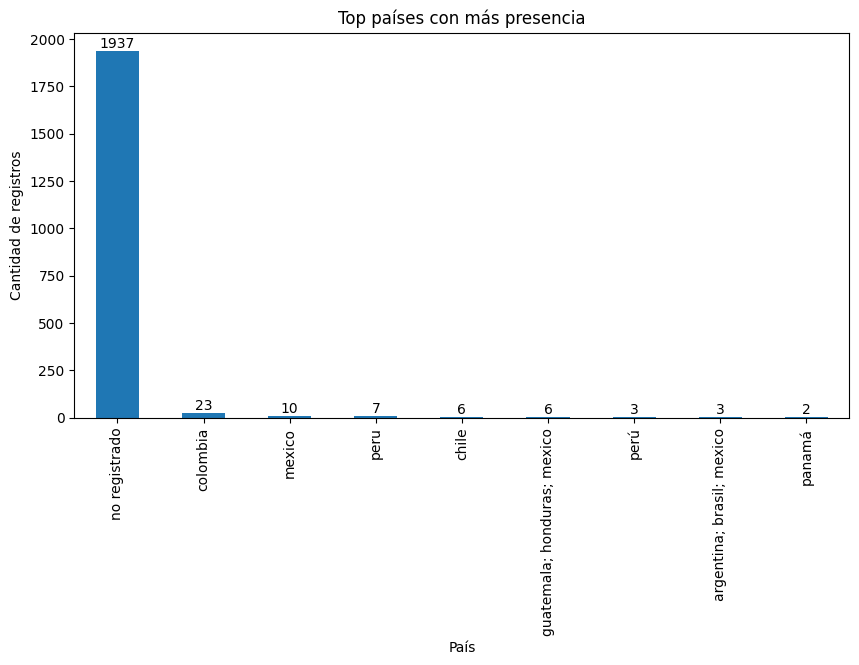

In [26]:
# CREACION DE SCRIPT para generar estadisticas y graficos
import pandas as pd
import matplotlib.pyplot as plt

# Ejemplo 1: Conteo por país
# cuantas veces aparece cada país en la columna Country Presence
# cada barra representa un pais, su altura son personas o campañas acociadas

print(df_api.describe())

conteo1 = df_api["Country Presence"].value_counts().head(10) ########

plt.figure(figsize=(10,5))
df_api["Country Presence"].value_counts().head(10).plot(kind='bar')
plt.title("Top países con más presencia")
plt.xlabel("País")
plt.ylabel("Cantidad de registros")

# para poner etiquetas con los valores encima de cada barra
for i, v in enumerate(conteo1.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')

plt.show()


**Insights del ejemplo 1:**
Claramente hay un severo caso falta de registros, esto hace que sea imposible saber en qué país se tiene más presencia realmente, aunque la segunda opción con mayor cantidad es colombia, facilmente podría ese no ser el país con más precencia debido a la gran cantidad de paises no registrados. Se deben implementar medidas para garantizar un registro más completo, como no poder mandar los informes sin la información completa, además de una mejor capacitación de quienes debe llevar los registros para verificar qué datos incluyen y cuales faltan.

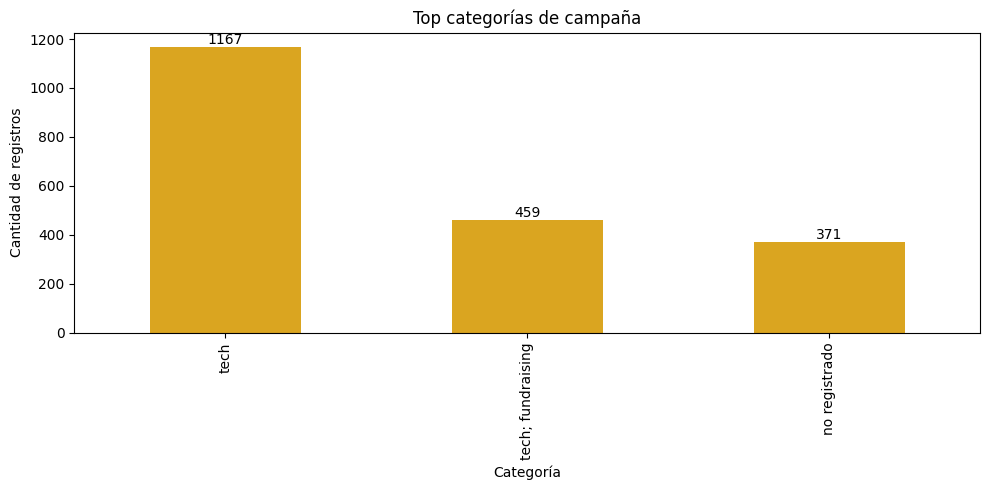

In [27]:
# Ejemplo 2: Campañas por categoría
# muestra cuántas campañas hay por cada categoría en un gráfico de barras horizontal

conteo2 = df_api["Campaign categories"].value_counts().head(10)
plt.figure(figsize=(10,5))
ax = conteo2.plot(kind='bar', color='goldenrod')
plt.title("Top categorías de campaña")
plt.xlabel("Categoría")
plt.ylabel("Cantidad de registros")
# poner etiquetas de valor en cada barra
for i, v in enumerate(conteo2.values):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

**Insights del ejemplo 2:**
Las campañas de "tech" son las más numerosas con porcentaje de 58.44%, mientras que las de "tech; fundraising" solo llegan a 22.99% siendo menos de la mitad de "tech", pero se ve que hay un 18.58% sin registrar, pero sin importar de cual tipo sean los sin registrar, "tech" seguría siendo la categoría con más registros, aunque sin la información de los no registrados nos estamos perdiendo de otra áreas en las que podríamos tener precensia.

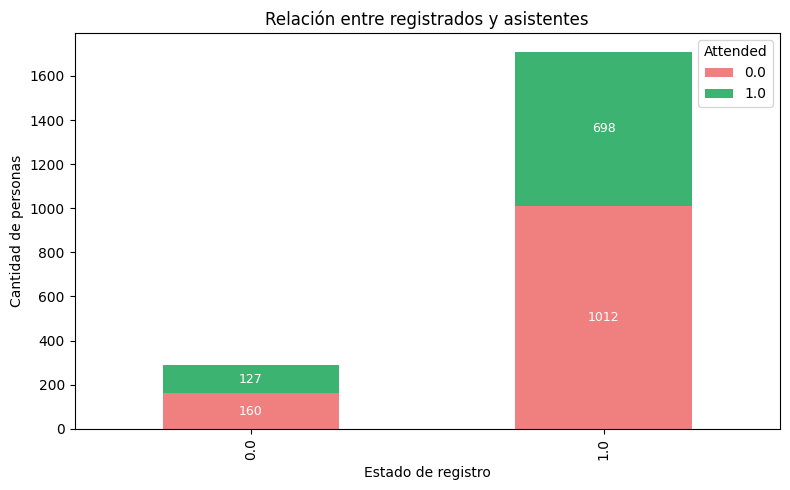

In [21]:
# Ejemplo 3: Relación entre registro y asistencia
# tabla de contingencia (crosstab) para cruzar dos columnas:
# Registered (personas que se registraron) y Attended (personas que asistieron)
# muestra cuantos registrados realmente asistieron y cuántos no

conteo3 = df_api.groupby(["Registered", "Attended"]).size().unstack(fill_value=0)
conteo3.plot(kind='bar', stacked=True, figsize=(8,5), color=['lightcoral','mediumseagreen'])
plt.title("Relación entre registrados y asistentes")
plt.xlabel("Estado de registro")
plt.ylabel("Cantidad de personas")
# etiquetas encima de las barras
for container in plt.gca().containers:
    plt.bar_label(container, label_type='center', fontsize=9, color='white')
plt.tight_layout()
plt.show()

**Insights del ejemplo 3:**
Se ve que hubo mayor cantidad de gente presente registrada que no registrada, pero de la gente que se llegó a registrar la mayor parte no asistió, lo que nos da un 40.82% de asistencia de parte de los asistentes registrados. Por lo tanto lo recomendable es implementar un sistema de recordatorios por correo o llamada a los participantes registrados.